100%|██████████| 9912422/9912422 [00:00<00:00, 84788173.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12494656.40it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23150822.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13559095.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



tensor(-4.2617) tensor(6.2805)
Epoch:1, Loss:0.0501
Epoch:2, Loss:0.0515
Epoch:3, Loss:0.0451
Epoch:4, Loss:0.0618
Epoch:5, Loss:0.0407
Epoch:6, Loss:0.0805
Epoch:7, Loss:0.0554
Epoch:8, Loss:0.0807
Epoch:9, Loss:0.0807
Epoch:10, Loss:0.0750


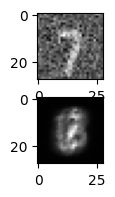

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

trans = transforms.ToTensor()

# Load the MNIST dataset
mnist_data_gauss = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Create a data loader to load the data in batches
data_loader_gauss = torch.utils.data.DataLoader(dataset=mnist_data_gauss, batch_size=64, shuffle=False)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=False)

dataiter = iter(data_loader_gauss)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))


# This is the definition of the Autoencoder model using a neural network with encoder and decoder modules.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Linear(98, 49),
            # nn.ReLU(),
            # nn.Linear(49, 16),
            # nn.ReLU(),
            # nn.Linear(16, 2)
        )

        self.decoder = nn.Sequential(
            # nn.Linear(2, 16),
            # nn.ReLU(),
            # nn.Linear(16, 49),
            # nn.ReLU(),
            nn.Linear(49, 98),
            nn.ReLU(),
            nn.Linear(98, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# These lines define the loss function (MSE loss), instantiate the Autoencoder model
# learning rate of 1e-3 and L2 regularization with a weight decay of 1e-5.
criterion = nn.MSELoss()
model = Autoencoder()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-10, momentum=0.9)

# train the model over n epochs
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for j in range(0,500):
        rand_index = random.randint(0, 49999)
    #for (img, _) in (mnist_data_gauss):
        img, _ = mnist_data_gauss[rand_index]
        img = img.reshape(-1, 28 * 28)
        recon = model(img)
        #loss = criterion(recon, img)

        real_img, _ = mnist_data[rand_index]
        real_img = real_img.reshape(-1, 28 * 28)
        loss = criterion(recon, real_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# Plot the resulting images
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

plt.show()